In [20]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import yfinance as yf


In [21]:
start_date = '2018-03-05'
end_date = '2020-08-16'

boyd = yf.download('BYD', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)

df_open = boyd["Open"]

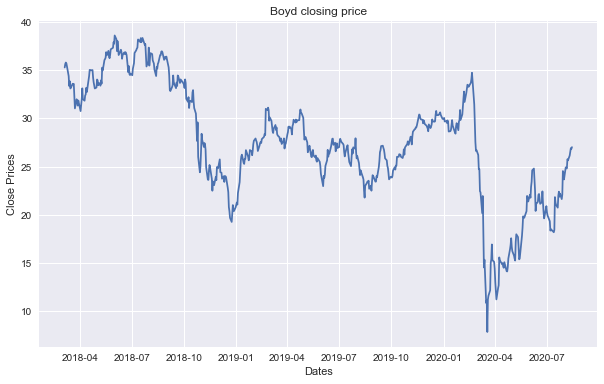

In [22]:
data = boyd
df_close = data['Close']

#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Boyd closing price')
plt.show()


In [90]:
#Test for staionarity


def test_stationarity(timeseries):
    
    fig = plt.figure()
    
    plt.plot(x=timeseries.index, y=timeseries, label = "chiu")
    
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    

    #plt.plot(x=boyd.index, y=boyd["Close"])
    
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
#test_stationarity(df_close)

In [97]:
from bqplot import pyplot as plt
fig = plt.figure(title = "Stock Price")
plt.plot(x=df_close.index, y=df_close, label = "chiu")
plt.show()

In [86]:
df = df_close.diff(1).dropna()

In [91]:
test_stationarity(df)

Results of dickey fuller test
Test Statistics               -7.675045e+00
p-value                        1.556873e-11
No. of lags used               8.000000e+00
Number of observations used    6.080000e+02
critical value (1%)           -3.441151e+00
critical value (5%)           -2.866305e+00
critical value (10%)          -2.569308e+00
dtype: float64


# Testing for Stationarity 

In [74]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='c',label='Original')
    #plt.plot(rolmean, color='red', label='Mean')
    #plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

Results of dickey fuller test
Test Statistics                 -2.281535
p-value                          0.177992
No. of lags used                10.000000
Number of observations used    607.000000
critical value (1%)             -3.441169
critical value (5%)             -2.866313
critical value (10%)            -2.569312
dtype: float64


- We can see that the data is not stationary because the p value of the DF test is high. This is also seen in the high mean and standard deviation values 

# Adjusting trend and Seasonality 

<Figure size 720x432 with 0 Axes>

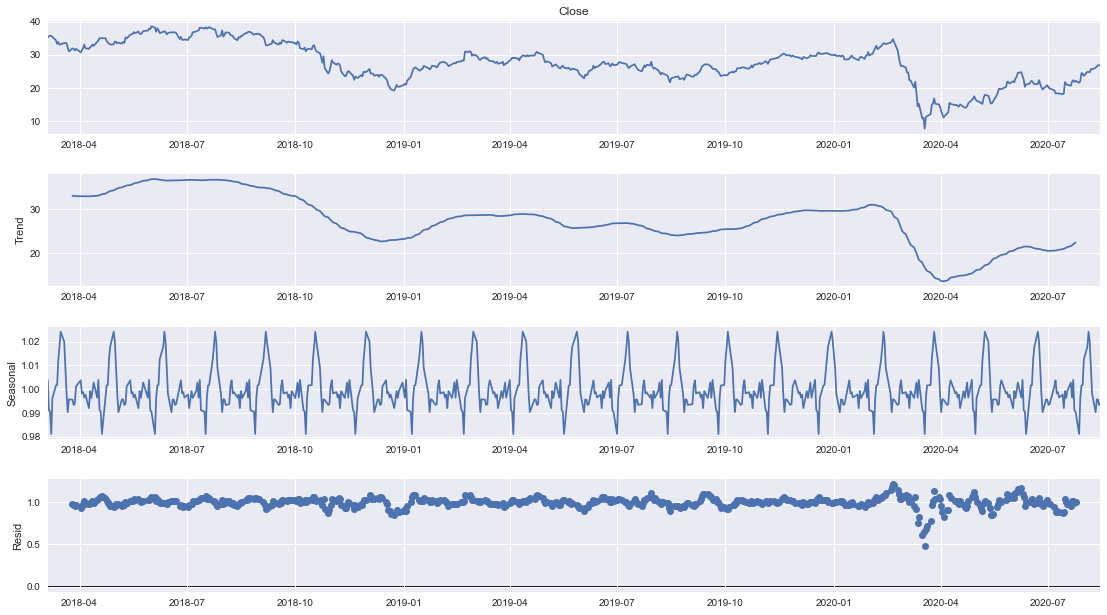

In [5]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

- To remove the trend, we do logarithmic scaling and for the seasonality we adjust it by taking a moving average of past 12 months 


No handles with labels found to put in legend.


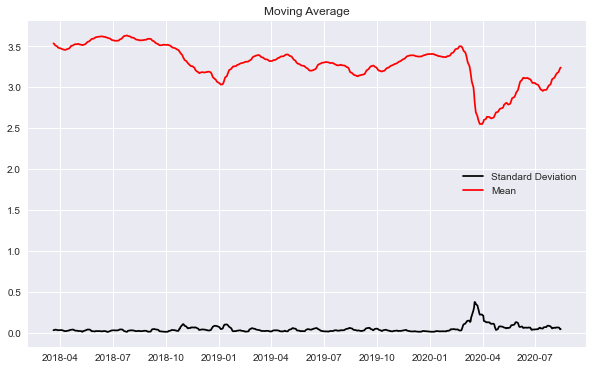

In [24]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

# Test and Train data split 

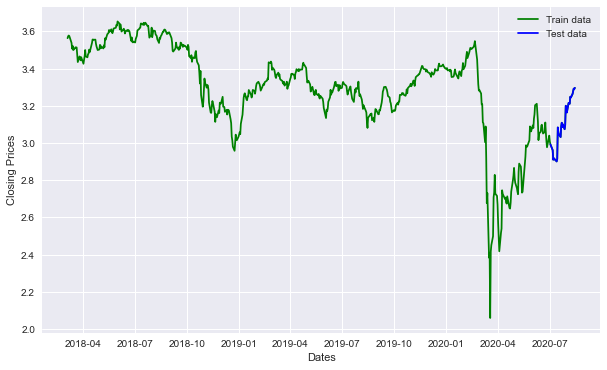

In [25]:
#split data into train and training set

#Tetsing with original data 
#df_log = df_close 
#from bqplot import pyplot as plt

train_test_split = 0.95
train_data, test_data = df_log[3:int(len(df_log)*train_test_split)], df_log[int(len(df_log)*train_test_split):]
plt.figure(figsize=(10,6))
#plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log , 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

# ARIMA Model Tuning 

In [26]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
#print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2037.369, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2037.356, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2036.651, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2039.056, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2047.815, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2080.253, Time=0.70 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2081.481, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2081.063, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2086.151, Time=0.83 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2081.456, Time=0.84 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2094.611, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2086.811, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2087.937, Time=0.97 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2084.951, Time=0.95 sec
 ARIMA(3,1,3)(0,0,0

- The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) 

- From the above analysis we can see that the (3,1,3) model has the best AIC score. So we can chose that as our p,d,q variables

- The residual errros seem to be around mean 0 but have high fluxuations in variance in post covid times

In [50]:
model = ARIMA(train_data, order=(3, 1, 3))  
fitted = model.fit(disp=-1)  
print(fitted.summary())



                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  583
Model:                 ARIMA(3, 1, 3)   Log Likelihood                1066.550
Method:                       css-mle   S.D. of innovations              0.039
Date:                Sat, 02 Jan 2021   AIC                          -2117.100
Time:                        13:16:59   BIC                          -2082.155
Sample:                             1   HQIC                         -2103.479
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0010      0.002     -0.493      0.622      -0.005       0.003
ar.L1.D.Close    -1.3843      0.179     -7.738      0.000      -1.735      -1.034
ar.L2.D.Close    -0.4027      0.303     

In [98]:
#Check stationaity of residuals 
test_stationarity(fitted.resid)

Results of dickey fuller test
Test Statistics               -1.182578e+01
p-value                        8.209996e-22
No. of lags used               5.000000e+00
Number of observations used    5.770000e+02
critical value (1%)           -3.441734e+00
critical value (5%)           -2.866562e+00
critical value (10%)          -2.569445e+00
dtype: float64


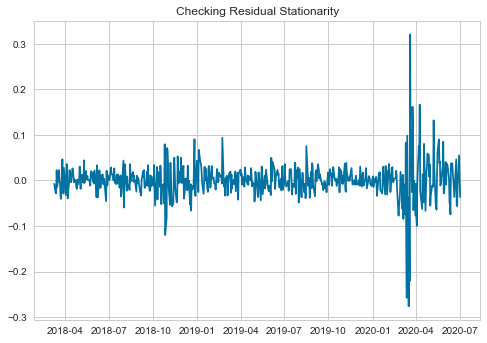

In [131]:
#from bqplot import pyplot as plt
fig = plt.figure()
plt.plot(fitted.resid.index, fitted.resid, label = "chiu")
plt.title("Checking Residual Stationarity")
plt.show()

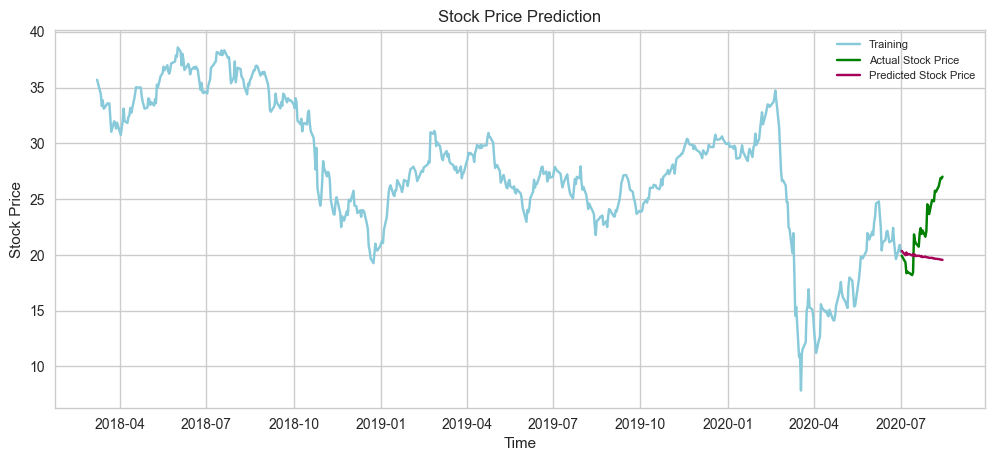

In [123]:
# Forecast
from yellowbrick.regressor import PredictionError, ResidualsPlot

fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.exp(train_data), color = 'c',label='Training')
plt.plot(np.exp(test_data), color = 'green', label='Actual Stock Price')
plt.plot(np.exp(fc_series), color = 'm',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper right', fontsize=8)
plt.savefig("arima2.png")
plt.show()

In [65]:
# report performance
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 16.73508092380962
MAE: 3.4123041941685077
RMSE: 4.090853324651181
MAPE: 5.403139829043599


In [66]:
trade = pd.DataFrame(np.exp(fc_series), columns = ["Predicted_Close"])

In [67]:
trade =trade.merge((boyd[['Adj Close', 'Open']]), left_index=True, right_index=True, how='left')


In [68]:
trade['returns_pred']  = trade.Predicted_Close.pct_change()
trade['signal'] = np.where(trade['returns_pred']>0 , 1, 0)
trade = trade.rename(columns={'Adj Close': 'Close'})
trade

,Predicted_Close,Close,Open,returns_pred,signal
Date,,,,,
2020-07-02,20.368687,19.940001,21.090000,NaN,0
2020-07-06,19.977715,19.330000,20.309999,-0.019195,0
2020-07-07,20.225220,18.360001,18.940001,0.012389,1
2020-07-08,20.012981,18.510000,18.190001,-0.010494,0
2020-07-09,20.073354,18.389999,18.610001,0.003017,1
2020-07-10,20.076053,18.389999,18.299999,0.000134,1
2020-07-13,19.952603,18.190001,18.740000,-0.006149,0
2020-07-14,20.084275,18.430000,18.459999,0.006599,1
2020-07-15,19.901626,21.840000,19.709999,-0.009094,0


Number of Trades: 22
Time Frame: 34 days
Profit: $-87.62 | -1.75%


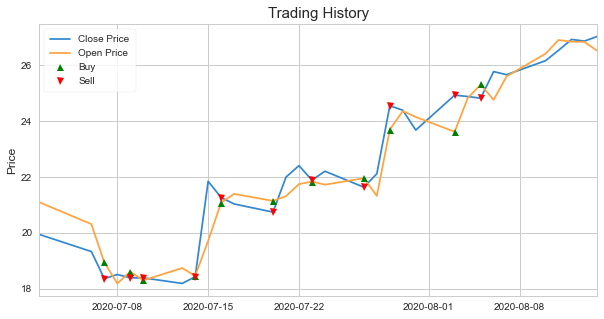

In [128]:

from matplotlib import pyplot as plt 
profit , net = long_only_trading(trade,'signal' ,5000, True, True )



In [126]:
def long_only_trading(stock,signal ,budget=15000, show_graph=True, show_return=True):
    
    state_check = lambda x, y: 1 if x > y else 0
    stock = stock.reset_index()    
    money = budget
    prev_state = state_check(stock.loc[0].Predicted_Close, stock.loc[0].Open)
    stock_amt = 0
    net = []
    
    for i in range(1, len(stock)):

        today = stock.iloc[i]
        if today[signal] == 1 : 
            #Buy at open price
            stock_amt = int(money / today.Open)
            money = 0
            net.append([today.Date, today.Open, 1, stock_amt * today.Close])
            
            
            #Sell at close price
            money = stock_amt * today.Close
            stock_amt = 0
            net.append([today.Date, today.Close, 0, money])
    
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - stock.loc[0].Date).days))
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net    
    
    
    
def trading_history(stock, net, std=2):    
    
    # Bollinger band plot with EMA and original historical data
    plt.figure(figsize=(10,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Close Price')
    plt.plot(stock.index, stock.Open, color='#ffa33f', label='Open Price')
    
    plt.title('Trading History', fontSize=15)
    plt.ylabel('Price', fontSize=12)
    plt.xlim([stock.index[0], stock.index[-1]])
    
    for i in net:
        if i[2] == 1: 
            color = 'green'
            marker = '^'
        else: 
            color = 'red'
            marker = "v"
        plt.plot_date(i[0], i[1], color=color, marker = marker )
        
    plt.plot_date([],[],label='Buy', c='green', marker = '^')
    plt.plot_date([],[],label='Sell', c='red', marker = "v")
        
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.savefig("ARIMA_trading_Strategy.png")
    plt.show()